In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk

from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer, TweetTokenizer
from nltk.stem import WordNetLemmatizer

import re

In [ ]:

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, silhouette_score

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

In [35]:
# import data
df = pd.read_csv("../data/brands_and_product_tweets.csv")
df

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
8716,Ipad everywhere. #SXSW {link},iPad,Positive emotion
8717,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
8718,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
8719,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [36]:
# rename columns

df = df.rename(columns = {'tweet_text': 'tweet',
                          'emotion_in_tweet_is_directed_at': 'product',
                          'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'})
df

,tweet,product,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
8716,Ipad everywhere. #SXSW {link},iPad,Positive emotion
8717,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
8718,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
8719,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8721 entries, 0 to 8720
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      8720 non-null   object
 1   product    3169 non-null   object
 2   sentiment  8721 non-null   object
dtypes: object(3)
memory usage: 204.5+ KB


In [17]:
# rename sentiment labels

df['sentiment'] = df['sentiment'].replace({"No emotion toward brand or product": "neutral",
                                           "Positive emotion": "positive",
                                           "Negative emotion": "negative",
                                           "I can't tell": "unclear"})

In [18]:
df['sentiment'].value_counts()

neutral     5156
positive    2869
negative     545
unclear      151
Name: sentiment, dtype: int64

In [19]:
df['product'].value_counts()

iPad                               910
Apple                              640
iPad or iPhone App                 451
Google                             412
iPhone                             288
Other Google product or service    282
Android App                         78
Android                             74
Other Apple product or service      34
Name: product, dtype: int64

In [40]:
# drop NaNs in tweets
df['tweet'].dropna(inplace=True)

# drop duplicate rows
df.drop_duplicates(inplace=True)

In [41]:
print(df.isna().sum())

tweet           1
product      5539
sentiment       0
dtype: int64


In [43]:
df['product'].fillna("undefined", inplace = True)

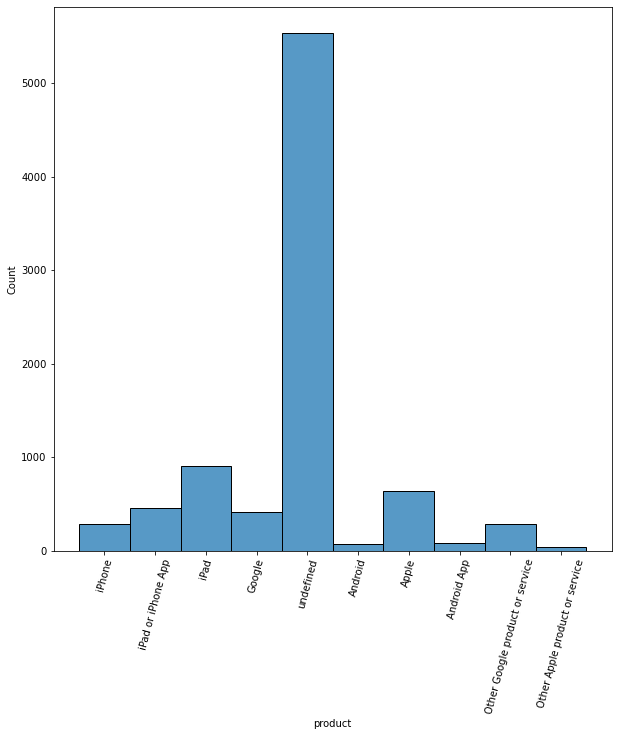

In [45]:
fig, ax = plt.subplots(figsize=(10,10))
sns.histplot(df["product"])
plt.xticks(rotation = 75)
plt.show()

In [ ]:
def product_brand(product, tweet):

    brand = 'undefined'

    if ((product.__contains__('google')) or (product.__contains__('android'))):
        brand = 'google'

    elif ((product.__contains__('apple')) or (product.__contains__('ip'))): 
        brand = 'apple'
    
    if (brand == 'undetermined'): 
        is_google = (lower_tweet.__contains__('google')) or (lower_tweet.__contains__('android')) #Undetermined google
        is_apple = (lower_tweet.__contains__('apple')) or (lower_tweet.__contains__('ip')) #Undetermined apple
        
        if (is_google and is_apple): #if it has both identifiers in the tweet
            brand = 'Both' #Labeling brand as both
        elif (is_google):
            brand = 'Google' #Labeling brand as Google
        elif (is_apple):
            brand = 'Apple' #Labeling brand as Apple
    
    return brand

df['Brand'] = df.apply(lambda x: find_brand(x['Product'], x['Tweet']), axis = 1) #Applying function to column
df['Brand'].value_counts() #Reviewing value counts of each class within brand

In [46]:
def clean_text(text):
    # Check if the text is a string
    if not isinstance(text, str):
        return ''  # Return empty string if text is not a string
    # Remove URLs items
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    text = re.sub(r'\@\w+|\#','', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove special characters and numbers
    text = re.sub(r"[^a-zA-Z']", ' ', text)
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    return text

# Clean the tweet_text column
df['cleaned_tweet_text'] = df['tweet'].apply(clean_text)

In [47]:
df

,tweet,product,sentiment,cleaned_tweet_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,g iphone hrs tweeting rise austin dead need up...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,know awesome ipad iphone app likely appreciate...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,wait ipad also sale sxsw
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,hope year's festival crashy year's iphone app ...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,great stuff fri sxsw marissa mayer google tim ...
...,...,...,...,...
8716,Ipad everywhere. #SXSW {link},iPad,Positive emotion,ipad everywhere sxsw link
8717,"Wave, buzz... RT @mention We interrupt your re...",undefined,No emotion toward brand or product,wave buzz rt interrupt regularly scheduled sxs...
8718,"Google's Zeiger, a physician never reported po...",undefined,No emotion toward brand or product,google's zeiger physician never reported poten...
8719,Some Verizon iPhone customers complained their...,undefined,No emotion toward brand or product,verizon iphone customers complained time fell ...


In [ ]:
# Initialize the WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to lemmatize text
def lemmatize_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    # Lemmatize each word
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Rejoin lemmatized tokens into a string
    lemmatized_text = ' '.join(lemmatized_tokens)
    return lemmatized_text

# Example text
example_text = "Fall Out Boy Rules."

# Lemmatize the example text
lemmatized_text = lemmatize_text(example_text)
print(lemmatized_text)

In [32]:
df.head(10)

,tweet,product,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,negative
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,positive
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,positive
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,negative
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,positive
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,neutral
6,NaN,NaN,neutral
7,"#SXSW is just starting, #CTIA is around the co...",Android,positive
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,positive
9,Counting down the days to #sxsw plus strong Ca...,Apple,positive
